# Energy and gradients

In [2]:
import sys
import pandas as pd
import numpy as np
from scipy import optimize

import json
import matplotlib.pylab as plt
try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')
%matplotlib inline

from tyssue import Sheet, SheetGeometry as geom

from tyssue.dynamics import SheetModel as model
from tyssue.solvers.sheet_vertex_solver import Solver as solver

from tyssue import config
import tyssue.dynamics.sheet_isotropic_model as iso
from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.plt_draw import quick_edge_draw, plot_forces
from tyssue.io import hdf5



# Energetical aspects of the epithelium


![Segmentation of the monolayer](../data/png/monolayer.png)


## Total energy of the epithelium

### Notations

Each cell is devided in tetrahedra, one per edge:

![Tetrahedral element](../data/png/maille_elementaire.png)

Each tetrahedron is thus indexed by its cell ($c$), face ($\alpha$), source vertex ($i$) and target vertex ($j$). For each of those tetrahedron, we will mostly use 
* the edge **length** between the source $i$ and the target j $\ell_{ij}$
* the **height** between the face center $\alpha$ and the  cell center $c$ $h_{c\alpha}$,
* the **area** of the face $(\alpha ij)$,
* and the volume $V_\ell{c\alpha ij}$ of the whole tetrahedron. 

Thanks to the chosen topology, there is only one tetrahedron per edge (or half-edge in CGAL terms), and the above defined values are defined as $N_e$ vectors, where $N_e$ is the number of edges. In the code, they have the same index as `eptm.edge_df`.


### Sums

We define operators that perform grouped summation $\bigoplus ()$, for example "sum the length of all the edges of a face". Such operators are applied to: 
* the source vertex i: $\bigoplus_s$,
* the target vertex j: $\bigoplus_t$,
* the junction edge ij: $\bigoplus_e$,
* the face $\alpha$ : $\bigoplus_f$ 
* the cell c: $\bigoplus_c$.

The connectivity is implicit, and those sums are performed as `groupby` operations over all the tetrahedra (`edge_df` indexed `DataFrames`).

This way, all the face perimeters are given by the vector of length $N_f$: 

$$\mathbf{L}_f = \bigoplus_f (\ell_{ij})$$ .

Similarly:

* For the face areas: $\mathbf{A}_f = \bigoplus_f(A_{\alpha ij})$.
* For the **cell** outside areas: $\mathbf{A}_c = \bigoplus_c (A_{\alpha ij})$.
* For the cell volumes: $\mathbf{V}_c = \bigoplus_c (V_{c\alpha ij})$

Very often, one wants to sum over all the out-going edges of a given jonction vertex (force balance, anyone?), wich is equivalent to summing over the source vertex.

* out-edges forces: $\mathbf{F}_i = \bigoplus_s (\mathbf{F}_{c\alpha ij})$


The more classic big sigma notation ($\sum_f$ etc.) defines a sum over all the faces of the epithelium, and returns a scalar for a 1D input.

### 2D potential

According to the [Farhadifar et
al. paper](http://dx.doi.org/10.1016/j.cub.2007.11.049), in the case
of a regular hexagonal latice, energy is given by:

$$
E = \sum_f\frac{K}{2} (A - A_0)^2 + \sum_f\frac{\Gamma}{2} L^2 +
\sum_e\frac{\Lambda}{2}\ell
$$

_The factor 1/2 in the linear term is due to the half-edge geometry, this is more tricky in full 3D_.


### 3D

This potential can be generalized to 3D by the adition of a volume term:

$$ E = \sum_c\frac{K_v}{2} (V_c - V_0)^2 + \sum_c\frac{K_a}{2} (A_\alpha - A_0)^2 + \sum_f\frac{\Gamma}{2}L_\alpha^2 + \sum_e\Lambda\ell_{ij} $$


### 2.5D

In the 2.5D case, the volume of a cell is given as $V_f = \bigoplus_f A_{\alpha ij}h_{i}$ where $h_i$ is the height of the source vertex of edge ${c, \alpha, i, j}$. The area elaticity is considered null.

# Forces


In a quasi-static approach, we want to compute the gradient of the energy at each vertex concuring to the optimisation. In a viscous dynamics approach, the same gradient will be use as the force term.

$$
\begin{aligned} 
   \mathbf{\nabla_i} E &= (\frac{\partial E}{\partial x},
                     \frac{\partial E}{\partial y},
                     \frac{\partial E}{\partial z}) \\
   \mathbf{\nabla_i} E &= K_c (V_c - V_0) \mathbf{\nabla_i} V_c + K_a (A_c - A_0) \mathbf{\nabla_i} A_c + \Gamma L_\alpha \mathbf{\nabla_i} L_\alpha  + \Lambda \mathbf{\nabla_i} \ell_{ij}
\end{aligned}
$$

### Expression of the gradients

* edge length $\mathbf{\nabla_i} \ell_{ij} = \frac{\mathbf{r}_{ij}}{\ell_{ij}}$
* area

## Energy landscape in 2.5D

In [10]:
h5store = '../data/hf5/small_hexagonal.hf5'
datasets = hdf5.load_datasets(h5store,
                              data_names=['face', 'vert', 'edge'])
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)


geom.update_all(sheet)



we define the adimentional contractility $\bar\Gamma = \Gamma/K_vA_0h_0^2$ and line tension
$\bar\Lambda = \Lambda /K_v (A_0^{3/2}h_0^2)$, where $h_0$ is such that $V_0 = A_0h_0$.


In [11]:

nondim_specs = config.dynamics.quasistatic_sheet_spec()
dim_model_specs = model.dimentionalize(nondim_specs)

sheet.update_specs(dim_model_specs, reset=True)
isotropic_relax(sheet, nondim_specs)

Reseting datasets values with new specs


In [12]:
Et, Ec, Ev = model.compute_energy(sheet, full_output=True)
energy = model.compute_energy(sheet, full_output=False)
print('Total energy: {}'.format(energy))

Total energy: 18.583115963252297


0.886592687387 0.897959183673


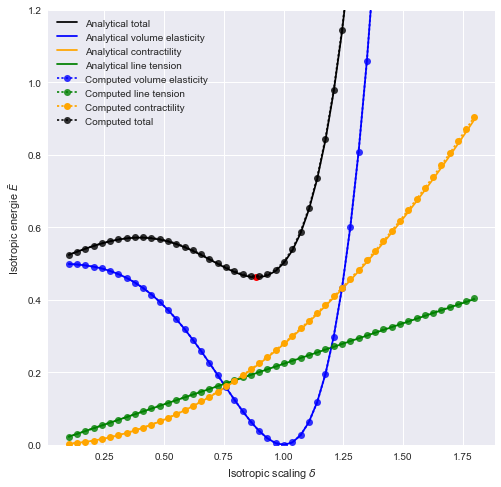

In [13]:
from tyssue.draw.plt_draw import plot_analytical_to_numeric_comp
fig, ax = plot_analytical_to_numeric_comp(sheet, model, geom, iso, nondim_specs)


In [8]:
model.compute_energy(sheet) / sheet.face_df.is_alive.sum() # should be around 0.46

0.46457789908130731

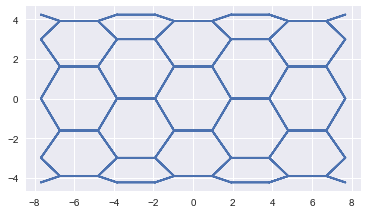

In [14]:
isotropic_relax(sheet, nondim_specs)

fig, ax = quick_edge_draw(sheet, ['z', 'x'])

In [15]:
grad_i = model.compute_gradient(sheet, components=False)
grad_i.head()

,x,y,z
srce,,,
0,0.010285,9.594520e-18,-0.019800
1,-0.002462,-1.019802e-03,-0.018335
2,0.007273,7.272515e-03,-0.019800
3,-0.002462,1.019802e-03,-0.018335
4,0.007040,-2.916054e-03,-0.001465


In [16]:
geom.scale(sheet, 2, sheet.coords)
geom.update_all(sheet)

In [17]:
bck_lt = sheet.edge_df.line_tension.copy()
bck_ct = sheet.face_df.contractility.copy()
bck_ve = sheet.face_df.vol_elasticity.copy()


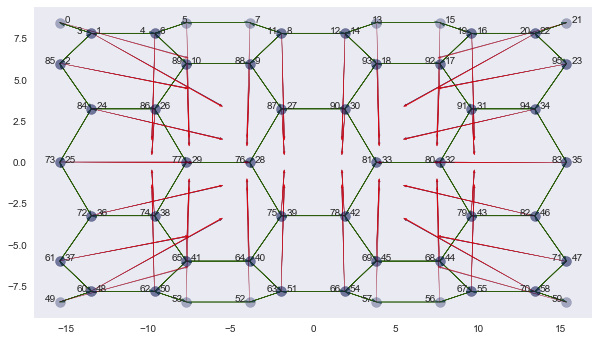

In [18]:
scale = 10
fig, ax = plot_forces(sheet, geom, model, ['z', 'x'], scale)
fig.set_size_inches(10, 12)
for n, (vx, vy, vz) in sheet.vert_df[sheet.coords].iterrows():
    shift = 0.6 * np.sign(vy)
    ax.text(vz+shift-0.3, vx, str(n))

app_grad_specs = config.draw.sheet_spec()['grad']
app_grad_specs.update({'color':'r'})
    
def draw_approx_force(ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    fig, ax = plot_forces(sheet, geom, model,
                          ['z', 'x'], scaling=scale, ax=ax,
                          approx_grad=solver.approx_grad, **{'grad':app_grad_specs})
    fig.set_size_inches(10, 12)
    return fig, ax

## Uncomment bellow to recompute
fig, ax = draw_approx_force(ax=ax)
#fig

http://scipy.github.io/devdocs/generated/scipy.optimize.check_grad.html#scipy.optimize.check_grad

In [19]:

grad_err = solver.check_grad(sheet, geom, model)
grad_err /= sheet.vert_df.size


print("Error on the gradient (non-dim, per vertex): {:.3e}".format(grad_err))


Error on the gradient (non-dim, per vertex): 3.994e-05


In [20]:
settings = {
    'minimize': {
        'options': {'disp':False,
                    'ftol':1e-5,
                    'gtol':1e-5},
        }
    }


res = solver.find_energy_min(sheet, geom, model, **settings)
print(res['success'])

True


In [21]:
res['message']

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [22]:
res['fun']/sheet.face_df.is_alive.sum()

0.46095843564267158

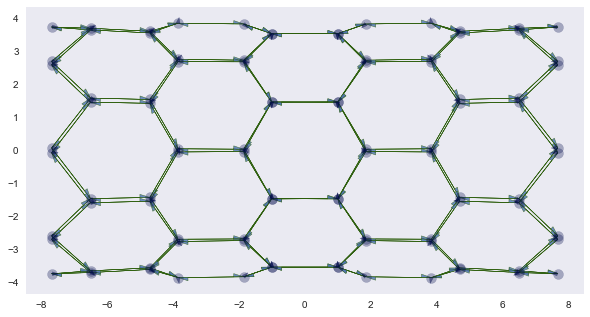

In [23]:
fig, ax = plot_forces(sheet, geom, model,
                      ['z', 'y'], scaling=1)
fig.set_size_inches(10, 12)
